In [ ]:
!pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.3/192.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 6.6 MB/s eta 0:00:00


In [ ]:
import deepxde as dde
from deepxde.backend import tf

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Enable just-in-time compilation with XLA.



In [ ]:
!pip install -U pysr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.9/93.9 kB 6.0 MB/s eta 0:00:00


In [ ]:
!pip install -U juliacall pysr

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term
Enable just-in-time compilation with XLA.



Compiling model...
Building feed-forward neural network...
'build' took 0.094287 s

'compile' took 3.827772 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.24e-01, 9.22e-03, 1.54e-02]    [1.54e-01, 9.22e-03, 1.54e-02]    []  
400       [1.39e-05, 5.38e-05, 1.54e-02]    [1.10e-05, 5.38e-05, 1.54e-02]    []  
800       [3.27e-05, 1.30e-04, 1.52e-02]    [3.13e-05, 1.30e-04, 1.52e-02]    []  
1200      [5.34e-05, 1.49e-04, 1.51e-02]    [4.55e-05, 1.49e-04, 1.51e-02]    []  
1600      [9.61e-05, 1.57e-04, 1.50e-02]    [6.28e-05, 1.57e-04, 1.50e-02]    []  
2000      [2.23e-04, 1.87e-04, 1.46e-02]    [1.28e-04, 1.87e-04, 1.46e-02]    []  
2400      [4.41e-04, 3.31e-04, 1.34e-02]    [3.31e-04, 3.31e-04, 1.34e-02]    []  
2800      [8.90e-04, 2.14e-04, 5.25e-03]    [8.76e-04, 2.14e-04, 5.25e-03]    []  
3200      [7.84e-04, 7.14e-05, 9.95e-04]    [5.22e-04, 7.14e-05, 9.95e-04]    []  
3600      [2.10e-04, 1.99e-05, 5.

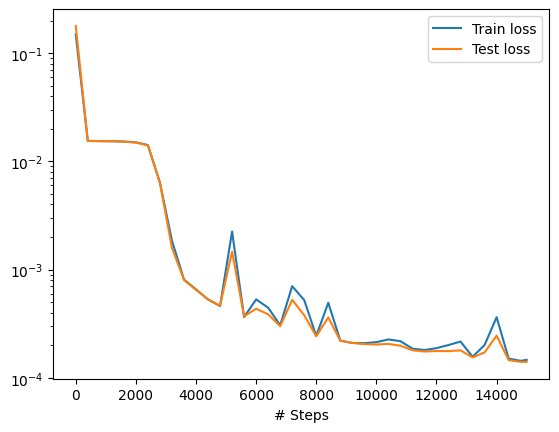

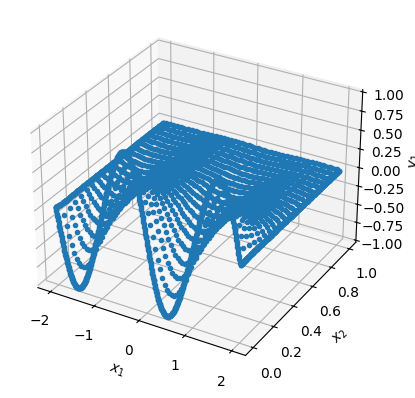

In [ ]:

import numpy as np
import pandas as pd
#%matplotlib inline
import matplotlib.pyplot as plt
import random
import deepxde as dde
import numpy as np
import deepxde as dde
from matplotlib import pyplot as plt
import numpy as np
import skopt
from skopt import gp_minimize
from skopt.plots import plot_convergence, plot_objective
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args

if dde.backend.backend_name == "pytorch":
    sin = dde.backend.pytorch.sin
else:
    from deepxde.backend import tf

    sin = tf.sin

# Clear TensorFlow session
tf.keras.backend.clear_session()
M = 0.2
# General parameters
epochs = 15000

def pde(x, y):
     dy_x = dde.grad.jacobian(y, x, i=0, j=0)
     dy_t = dde.grad.jacobian(y, x, i=0, j=1)
     dy_xx = dde.grad.hessian(y, x, i=0, j=0)
     dy_xxx = dde.grad.hessian(dy_x, x, i=0, j=0)
     #dy_xxxx = dde.grad.hessian(dy_xx, x, i=0, j=0)
     dy_xxxxx = dde.grad.hessian(dy_xxx, x, i=0, j=0)

     #dy_t + y * dy_x - 0.5*dy_xx -(M*0.5) * y
     #dy_t + y * dy_x + 0.5*dy_xxx -(M*0.5) * y
     #dy_t + y * dy_x + 0.5*dy_xxxx -(M*0.5) * y
     #dy_t + y * dy_x + 0.5*dy_xxx + 0.5*dy_xxxxx-(M*0.5) * y

     return dy_t + y * dy_x - 0.5*dy_xx -(M*0.5) * y

#geom = dde.geometry.Polygon([[0, 0], [1, 0], [1, -1], [-1, -1], [-1, 1], [0, 1]])
geom = dde.geometry.Interval(-2, 2)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.IC(geomtime, lambda x: -np.sin(np.pi * x[:, 0:1]), lambda _, on_initial: on_initial)
#data = dde.data.TimePDE(geomtime, pde, [bc, ic], num_domain=1000,  num_boundary=150, num_initial=100,num_test=1296)
data = dde.data.TimePDE(geomtime, pde, [bc, ic], num_domain=2500, num_boundary=700, num_initial=600,num_test=1500 )
# The last one is final for our paper

# [0.00014162001602662018, 4, 16, 'sin', lamda=0.03110204078235363]
lamda=0.03110

net = dde.nn.FNN([2] + [30] * 5 + [1], "sin", "Glorot normal")
model1 = dde.Model(data, net)
model1.compile("adam", lr=1.0e-3, loss_weights=(1, 1, lamda))
losshistory, train_state =model1.train(iterations=epochs,display_every=400)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)


In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.use('pgf')
import tensorflow as tf
import numpy as np
import scipy.io
from scipy.interpolate import griddata
import time
from itertools import product, combinations
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
#from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

In [ ]:
tps = 201
t=np.linspace(0,1,tps).reshape(-1,1)
x=np.linspace(-2,2,tps).reshape(-1,1)
xx, tt = np.meshgrid(x, t)
X = np.vstack((np.ravel(xx), np.ravel(tt))).T

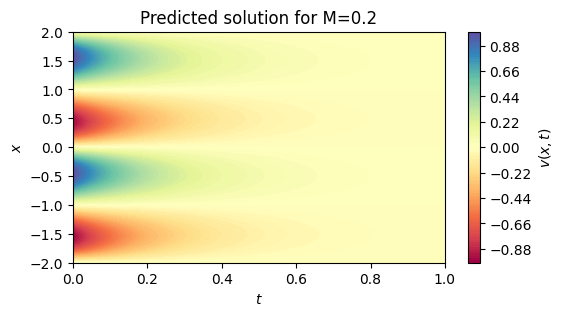

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate time (t) and space (x) grids
#t = np.linspace(0, 1, 101).reshape(-1, 1)  # 101 evenly spaced points between 0 and 2
#x = np.linspace(-1, 1, 101).reshape(-1, 1)  # 101 evenly spaced points between -1 and 1

# Create 2D grids (xx and tt) from 1D x and t arrays
#xx, tt = np.meshgrid(x, t)

# Stack the xx and tt grids to form the input data matrix X
#X = np.vstack((np.ravel(xx), np.ravel(tt))).T


# Predict the solution using the current model
y_pred = model1.predict(X)

# Reshape the predicted solution into the 2D domain
U_pred = y_pred.flatten().reshape(tps, tps)

# Visualize results for each M
plt.figure(figsize=(6, 3))
plt.contourf(tt, xx, U_pred, 100, cmap="Spectral")
plt.title(f"Predicted solution for M={M}")
plt.colorbar(label="$v(x,t)$")
plt.xlabel("$t$")
plt.ylabel("$x$")
plt.show()


In [ ]:
# Generating time (t) and space (x) grids
#t=np.linspace(0,1,101).reshape(-1,1) # 101 evenly spaced points between 0 and 1, reshaped to a column vector
#x=np.linspace(-2,2,101).reshape(-1,1)# 101 evenly spaced points between 0 and 10, reshaped to a column vector
# Creating 2D grids (xx and tt) from 1D x and t arrays
#xx, tt = np.meshgrid(x, t)
# Stacking the xx and tt grids to form the input data matrix X
#X = np.vstack((np.ravel(xx), np.ravel(tt))).T

# Predicting ts[0].predict(X)
# Predicting the residual using the trained model
f = model1.predict(X, operator=pde)
print("Mean residual:", np.mean(np.absolute(f)))
#U_pred =y_pred.flatten().reshape(101,101) # Predicted solution Over the 2D domain

Mean residual: 0.0035238622


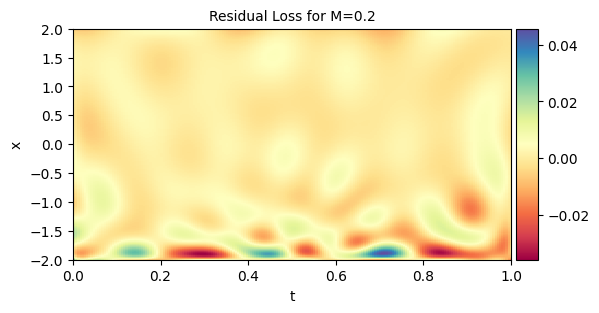

In [ ]:
fig, ax = plt.subplots(figsize=(6, 3))

# Plot the 2D image of the residual using imshow
h = ax.imshow(f.reshape(tps, tps), interpolation='nearest', cmap='Spectral',
              extent=[t.min(), t.max(), x.min(), x.max()],
              origin='lower', aspect='auto')

# Add a colorbar for the image
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

# Set the labels, title, and legend for the plot
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_title(f"Residual Loss for M={M}", fontsize=10)

# Save the plot as 'u_residual.eps' with dpi (dots per inch) set to 100
plt.savefig('Residual_comb.eps', dpi=300)

Computed indices: [0, 40, 80, 120]


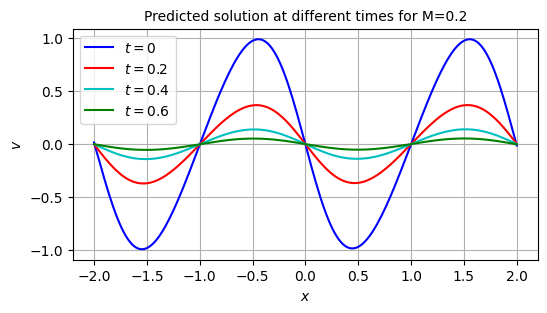

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters for time discretization
T = 1.0   # Total time
N_t = 201  # Number of time steps
delta_t = T / (N_t - 1)

# Time points of interest
time_points = [0, 0.2, 0.4, 0.6]

# Compute indices
indices = [round(t / delta_t) for t in time_points]
print("Computed indices:", indices)


# Create the figure and axis
fig, ax = plt.subplots(figsize=(6, 3))

# Colors for each time slice
colors = ['b-', 'r-', 'c-', 'g-']

# Plotting invisible lines with labels for legend
for t, color in zip(time_points, colors):
    ax.plot([], [], color, label=f'$t = {t}$')

# Plotting the function slices at specified time points
for idx, color in zip(indices, colors):
    ax.plot(x, U_pred[idx, :], color)

# Adding labels and title
ax.set_xlabel('$x$')
ax.set_ylabel('$v$')
ax.legend()

# Set the title
ax.set_title(f"Predicted solution at different times for M={M}", fontsize=10)

# Save the figure
plt.savefig('w_slice_comb.eps', dpi=300, bbox_inches='tight')

# Display the plot
plt.grid()
plt.show()


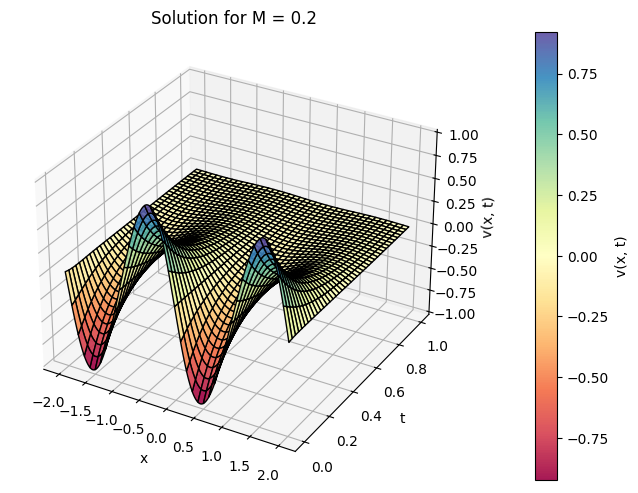

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Assuming x, t, and U_pred are defined

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(
        xx, tt, U_pred, cmap="Spectral", edgecolor="k", alpha=0.9
    )

# Add color bar
cbar = fig.colorbar(surf, ax=ax, pad=0.1)
cbar.set_label("v(x, t)")

# Customize the plot
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel("v(x, t)")
ax.set_title(f"Solution for M = {M}")
#ax.view_init(10, 290)  # Set the viewing angle for better 3D perspective

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

# Assuming you have already computed U_pred
data0 = {'x': xx.flatten(), 't': tt.flatten(), 'type': [0] * len(xx.flatten()),'y_pred': U_pred.flatten()}
df0 = pd.DataFrame(data0)

In [ ]:
X = df0[['t','x']].values
y = df0['y_pred'].values

In [ ]:
df0

,x,t,type,y_pred
0,-2.00,0.0,0,0.015308
1,-1.98,0.0,0,-0.055434
2,-1.96,0.0,0,-0.126275
3,-1.94,0.0,0,-0.196744
4,-1.92,0.0,0,-0.266376
...,...,...,...,...
40396,1.92,1.0,0,0.003916
40397,1.94,1.0,0,0.003667
40398,1.96,1.0,0,0.003428
40399,1.98,1.0,0,0.003203


In [ ]:
import pysr
import sympy
import numpy as np
from matplotlib import pyplot as plt
from pysr import PySRRegressor
from sklearn.model_selection import train_test_split

# Extract features and target variable
X_raw = df0[['x', 't']].values
y = df0['y_pred'].values

# Fit the PySR model
model = PySRRegressor(
    niterations=27,
    batching=True,
    batch_size=264,
    fast_cycle=True,
    binary_operators=["+", "*", "-", "/"],
    unary_operators=["exp", "sin", "cos"],
    populations=30,
    model_selection='best',
    #maxsize=30,
)
model.fit(X_raw, y)

/usr/local/lib/python3.11/dist-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 4.060e+02
Progress: 53 / 810 total iterations (6.543%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           4.972e-02  1.594e+01  y = -6.9268e-05
3           4.650e-02  3.347e-02  y = x₀ * 0.053419
4           4.649e-02  2.342e-04  y = x₀ * cos(-1.5184)
7           4.215e-02  3.263e-02  y = (0.017102 / (x₁ - -0.063697)) * x₀
10          4.206e-02  7.547e-04  y = sin(sin(x₀ * -0.1887)) * cos(x₀ / 0.83391)
11          3.018e-02  3.318e-01  y = (0.042281 - (0.10543 / -0.657)) * sin(sin(x₀ / -0.3129...
                                      8))
12          2.572e-02  1.599e-01  y = 0.0070888 - ((sin(x₀ / -0.31745) * -0.31542) * sin(cos...
                                      (x₁)))
16          1.063e-02  2.210e-01  y = sin(0.042281 - ((0.10543 / ((x₁ + cos

[ Info: Final population:
[ Info: Results saved to:


PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                     -0.00043851137   
	1         0.033736                                   x0 * 0.049121752   
	2         0.147732                 sin(x0 / -0.32048455) * 0.18983428   
	3         0.000034            sin(sin(x0 / -0.32040125) * 0.19082548)   
	4         0.975289            sin(x0 * 3.1146047) * (x1 + -0.6867531)   
	5         0.115437       exp(x1 * -2.8954809) * sin(x0 / -0.32346883)   
	6         2.837472   exp(x1 * -4.4298806) * sin(sin(x0 / -0.3204865))   
	7         0.073020  (x1 + -0.8496795) * ((sin(x0 / -0.3214893) * -...   
	8         0.150046  sin(x0 / -0.31979772) * sin((x1 + -0.8679636) ...   
	9         0.027540  sin(x0 / -0.3211688) * ((cos(x1) * (x1 + -0.85...   
	10        0.108253  cos(x1) * ((((sin(x1) + -0.7859481) * sin(x0 /...   
	11  >>>>  0.158166  ((exp(x1 * -3.7568195) * sin(x0 / -0.32158756)...   
	12        0.000153  cos(x1 + 0.12511149) * (exp(x1 * -2.3256638) *...   
	13        0.008601  (exp(x1 * -1.7162503) * sin((-0.07130724 / (((...   
	14        0.006338  cos(1.0503713 * (0.11911169 + x1)) * (exp(x1 *...   
	15        0.000523  (exp(x1 * -2.3256638) * cos((x1 * exp(0.062671...   
	
	        loss  complexity  
	0   0.049717           1  
	1   0.046473           3  
	2   0.029835           6  
	3   0.029834           7  
	4   0.011250           8  
	5   0.010023           9  
	6   0.000587          10  
	7   0.000438          14  
	8   0.000377          15  
	9   0.000357          17  
	10  0.000320          18  
	11  0.000274          19  
	12  0.000273          25  
	13  0.000271          26  
	14  0.000269          27  
	15  0.000269          28  
]

  - outputs/20250318_084047_5Tdabv/hall_of_fame.csv


In [ ]:
print(model.sympy())

exp(x1*(-3.7568195))*sin(x0/(-0.32158756))*(-0.32088187)/((x1*0.5604544 + 0.41065678)*(-0.79688895))


In [ ]:
print(model.latex())

e^{x_{1} \left(-3.76\right)} \sin{\left(\frac{x_{0}}{-0.322} \right)} \left(-0.321\right) \frac{1}{\left(-0.797\right) \left(x_{1} \cdot 0.560 + 0.411\right)}


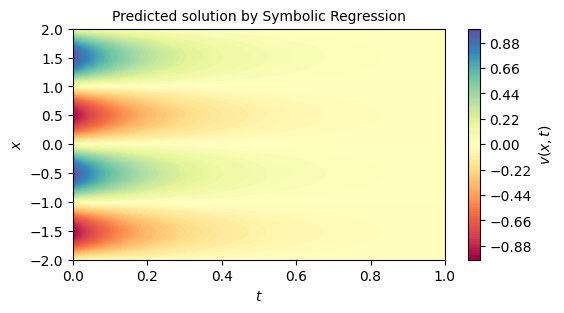

In [2]:
t=np.linspace(0,1,201).reshape(-1,1)
x=np.linspace(-2,2,201).reshape(-1,1)
xx, tt = np.meshgrid(x, t)
X = np.vstack((np.ravel(xx), np.ravel(tt))).T


def my_function(x0, x1):
    term1 =np.exp(x1*(-3.7568195))*np.sin(x0/(-0.32158756))*(-0.32088187)/((x1*0.5604544 + 0.41065678)*(-0.79688895))
    term2 = 0
    return (term1)

U_SymReg = my_function(xx, tt)

plt.figure(figsize=(6, 3))
contour= plt.contourf(tt, xx, U_SymReg, 100, cmap="Spectral")
plt.colorbar(contour, label="$v(x,t)$")
plt.xlabel("$t$")
plt.ylabel("$x$")
plt.title('Predicted solution by Symbolic Regression', fontsize = 10)
plt.show()

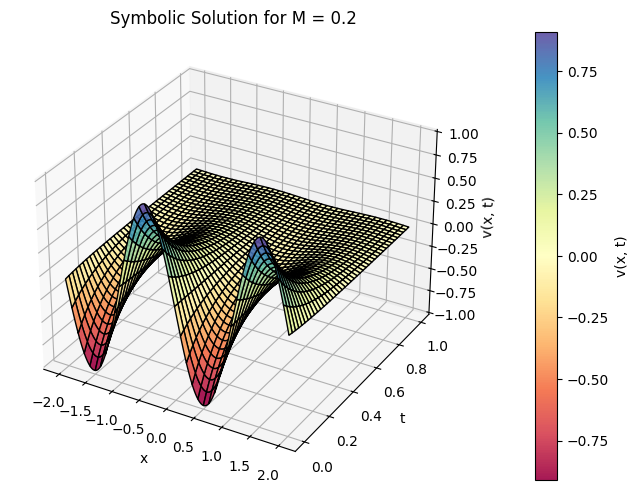

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Assuming x, t, and U_pred are defined

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(
        xx, tt, U_SymReg, cmap="Spectral", edgecolor="k", alpha=0.9
    )

# Add color bar
cbar = fig.colorbar(surf, ax=ax, pad=0.1)
cbar.set_label("v(x, t)")

# Customize the plot
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel("v(x, t)")
ax.set_title(f"Symbolic Solution for M = {M}")
#ax.view_init(10, 290)  # Set the viewing angle for better 3D perspective

plt.tight_layout()
plt.show()

Computed indices: [40, 80, 120]


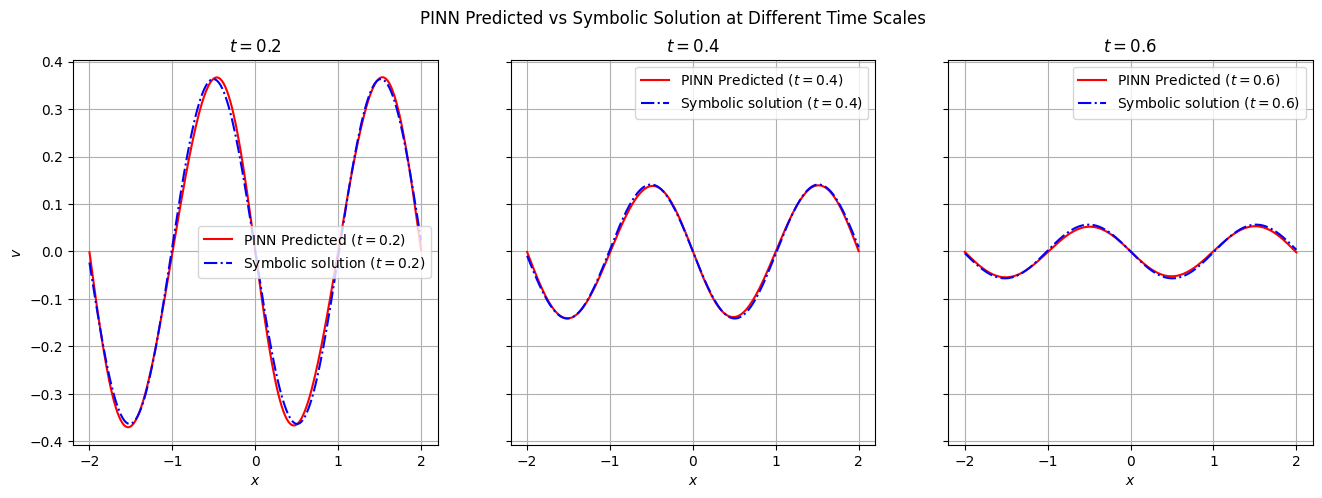

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters for time discretization
T = 1.0    # Total time
N_t = 201  # Number of time steps
delta_t = T / (N_t - 1)

# Define spatial domain (assuming this is given)
#x = np.linspace(-2, 2, 101)  # Example spatial domain

# Example simulated U_pred (assuming a placeholder function)
#U_pred = np.sin(np.pi * x) * np.exp(-0.5 * np.array([t/delta_t for t in range(N_t)])[:, None])

def my_function(x0, x1):
    term1 =np.exp(x1*(-3.7568195))*np.sin(x0/(-0.32158756))*(-0.32088187)/((x1*0.5604544 + 0.41065678)*(-0.79688895))
    term2 = 0
    return (term1)

# Time points of interest
time_points = [0.2, 0.4, 0.6]  # Three time slices

# Compute indices
indices = [round(t / delta_t) for t in time_points]
print("Computed indices:", indices)

# Evaluate the function over the grid
U_SymReg = my_function(xx, tt)

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=True)

# Colors for predicted and actual solutions
pred_color = 'r'
actual_color = 'b'

# Plot each slice in a separate subplot
for ax, idx, t in zip(axes, indices, time_points):
    ax.plot(x, U_pred[idx, :], pred_color, label=f'PINN Predicted ($t = {t}$)')
    ax.plot(x, U_SymReg[idx, :], actual_color, linestyle='-.', label=f'Symbolic solution ($t = {t}$)')
    ax.set_xlabel('$x$')
    ax.set_title(f'$t = {t}$')
    ax.grid()
    ax.legend()

# Global figure settings
axes[0].set_ylabel('$v$')  # Set only on the first subplot for clarity
fig.suptitle("PINN Predicted vs Symbolic Solution at Different Time Scales", fontsize=12)

# Save and show the figure
plt.savefig('w_slice_comparison.eps', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
print("Mean residual error of Symbolic Regression model is: ", np.mean(np.absolute(U_SymReg)))
print("Mean absolute error between PINN and Symbolic solution:", np.mean(np.absolute(U_pred-U_SymReg)))
print("Percentage error= ",(np.mean(np.absolute(U_pred-U_SymReg)))*100)

Mean residual error of Symbolic Regression model is:  0.128695106442075
Mean absolute error between PINN and Symbolic solution: 0.008409441671539454
Percentage error=  0.8409441671539455
